<h1 style = "color:orange;" dir = "ltr"> <b>
    Introduction to Artificial Intelligence
</b> </h1>

<h1 style = "color:orange;" dir = "ltr"> <b>
    CA3 - Clustering
</b> </h1>

<h1 style = "color:orange;" dir = "ltr"> <b>
    Mahdi Naieni - 810101536 
</b> </h1>

<h1 style = "color:red;text-align: center;font-size:50px"> <b>
    Introduction
</b> </h1>

<h1 style = "color:green;font-size:30px" dir = "ltr"> <b>
    Project Summary and Objectives:
</b> </h1>

In this project, our goal is to analyze a collection of flower images using clustering algorithms to categorize them into distinct groups based on their visual characteristics. By applying these algorithms, we aim to organize the images into clusters that reflect their similarities, potentially revealing previously unseen patterns or relationships among the flowers.

In [1]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.layers import Flatten, Dense
from keras.models import Model
from sklearn.metrics.cluster import homogeneity_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer, FunctionTransformer
import matplotlib.pyplot as plt
import warnings
import os
import numpy as np
import random
import seaborn as sns
import pandas as pd

directory_path = "flower_images"
labels_csv_file = "flower_labels.csv"

<h1 style = "color:green;font-size:30px" dir = "ltr"> <b>
    Understanding and Exploring the Dataset:
</b> </h1>

In this project, we utilize a dataset comprising numerous color photographs of various flower types. Accompanying these images is a CSV file that assigns labels to each image, serving as a comprehensive reference for the flowers' categories. These categories will be instrumental in the evaluation phase of our project, allowing us to assess the accuracy and effectiveness of our clustering algorithms in accurately categorizing the flowers based on their visual characteristics.

In [2]:
def load_original_images(directory_path):
    images = []
    features_label = []
    labels_df = pd.read_csv(os.path.join(directory_path, labels_csv_file))
    labels_dict = labels_df.set_index("file")["label"].to_dict()
    entries = os.listdir(directory_path)

    for _, entry in enumerate(entries):
        if os.path.isfile(os.path.join(directory_path, entry)) and entry.endswith(".png"):
            img_path = os.path.join(directory_path, entry)
            img = image.load_img(img_path, target_size=(224, 224))
            images.append(np.expand_dims(img, axis=0))
            features_label.append(labels_dict[entry])

    return np.vstack(images), features_label

def plot_images(images_arr, labels_arr):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20,20))
    axes = axes.flatten()
    for img, lbl, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(lbl)
    plt.tight_layout()
    plt.show()

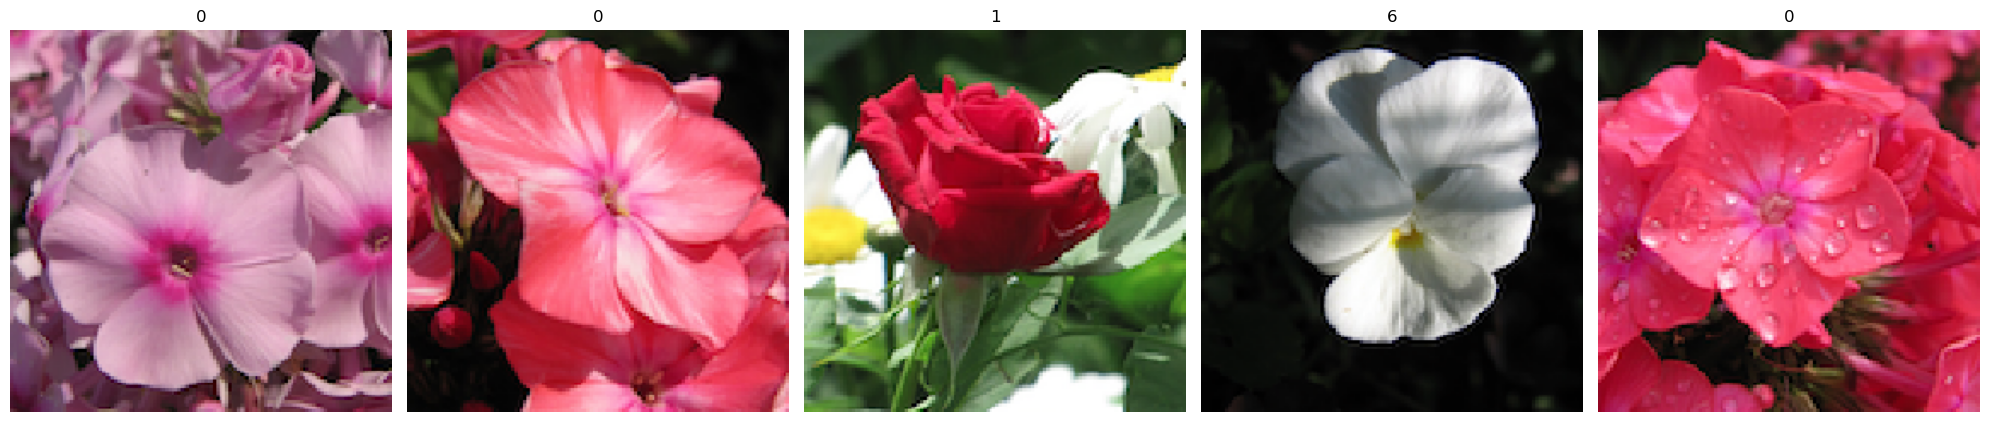

In [3]:
images, labels = load_original_images(directory_path)
plot_images(images[3:8], labels[3:8])

<h1 style = "color:red;text-align: center;font-size:50px"> <b>
    Preprocessing and Feature Extraction
</b> </h1>

<h1 style = "color:green;font-size:30px" dir = "ltr"> <b>
    Preprocessing:
</b> </h1>

In [4]:
warnings.filterwarnings("ignore")
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    reshaped_img = np.expand_dims(img, axis=0)
    processed_img = preprocess_input(reshaped_img)
    return processed_img

def load_images(directory_path):
    images = []
    features_label = []
    labels_df = pd.read_csv(os.path.join(directory_path, labels_csv_file))
    labels_dict = labels_df.set_index("file")["label"].to_dict()
    entries = os.listdir(directory_path)

    for _, entry in enumerate(entries):
        if os.path.isfile(os.path.join(directory_path, entry)) and entry.endswith(".png"):
            img_path = os.path.join(directory_path, entry)
            images.append(preprocess_image(img_path))
            features_label.append(labels_dict[entry])

    return np.vstack(images), features_label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


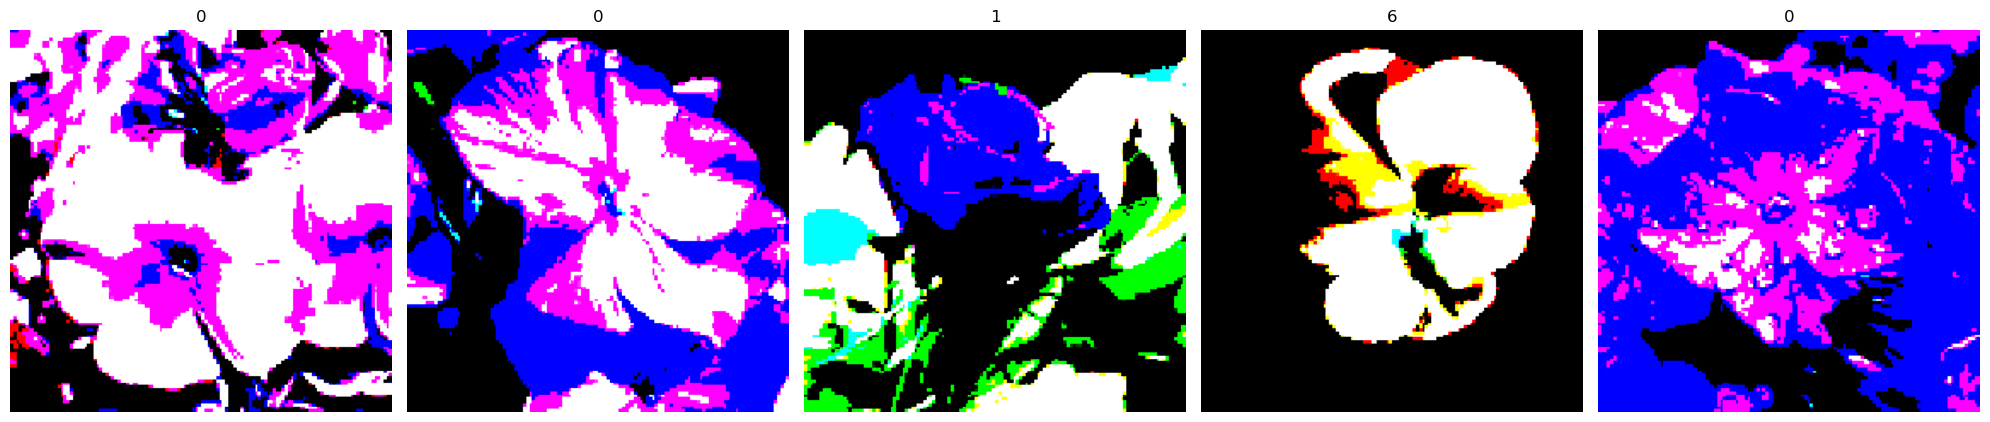

In [5]:
images, labels = load_images(directory_path)
plot_images(images[3:8], labels[3:8])

<h1 style = "color:green;font-size:30px" dir = "ltr"> <b>
    Feature Extraction:
</b> </h1>

VGG16 is a convolutional neural network (CNN) architecture that was developed by the Visual Geometry Group at the University of Oxford. It was first introduced in 2014, and since then, it has become one of the most popular deep learning models for image recognition.

The VGG16 model consists of 16 layers, including 13 convolutional layers and 3 fully connected layers. Each convolutional layer has a 3x3 filter size and a stride of 1 pixel. The pooling layers are used to downsample the feature maps and reduce the spatial size of the input. The fully connected layers are used to classify the images based on the extracted features.

![image](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*lXCy8RLUOtAwoS2H4ortZA.png)

In [6]:
def extract_features(images):
    model = VGG16(weights='imagenet', include_top=False)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    features = model.predict(images)
    return features

def scaled_features(features, n_components, random_state):
    reshaped_features = features.reshape(len(features), -1)
    scaler = FunctionTransformer()
    features_scaled = scaler.fit_transform(reshaped_features)
    scaler = Normalizer()
    features_scaled = scaler.fit_transform(features_scaled)
    pca = PCA(n_components = n_components, random_state = random_state)
    pca.fit(features_scaled)
    features_scaled = pca.transform(features_scaled)
    return features_scaled


In [7]:
model = VGG16(weights='imagenet', include_top=False)
features = extract_features(images)
features_scaled = scaled_features(features, 40, 57)

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


<h1 style = "color:red;text-align: center;font-size:50px"> <b>
    Dimension reduction
</b> </h1>

<h1 style = "color:green;font-size:30px" dir = "ltr"> <b>
    Principal Component Analysis (PCA):
</b> </h1>

Principal Component Analysis (PCA) is a widely used unsupervised machine learning algorithm for dimensionality reduction. It was introduced by Karl Pearson in 1901 and is based on the idea of transforming a set of correlated variables into a set of uncorrelated variables, known as principal components.

The main goal of PCA is to reduce the dimensionality of a dataset while preserving the most important patterns or relationships between the variables. This is achieved by identifying a new set of variables that are smaller than the original set but retain most of the sample's information. PCA is particularly useful in exploratory data analysis, predictive modeling, and visualizing high-dimensional data. It helps in finding the most significant features in a dataset, making the data easier to plot in 2D and 3D, and is applicable in various fields such as healthcare, finance, and image processing.

![image](http://www.nlpca.org/fig_pca_principal_component_analysis.png)

In [8]:
def get_pca_features(features_scaled, n_components, random_state):
    pca = PCA(n_components = n_components, random_state = random_state)
    pca.fit(features_scaled)
    features_pca = pca.transform(features_scaled)
    return features_pca

def plot_2D_scatterplot(features_scaled, pred_labels):
    plt.figure(figsize=(6, 5))
    features_pca = get_pca_features(features_scaled, 2, 45)
    sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=pred_labels, palette='viridis')
    plt.show()

def plot_3D_scatterplot(features_scaled, pred_labels):
    features_pca = get_pca_features(features_scaled, 3, 45)
    fig = plt.figure(figsize=(6.4, 6.4))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], c=pred_labels, cmap='viridis')
    plt.show()

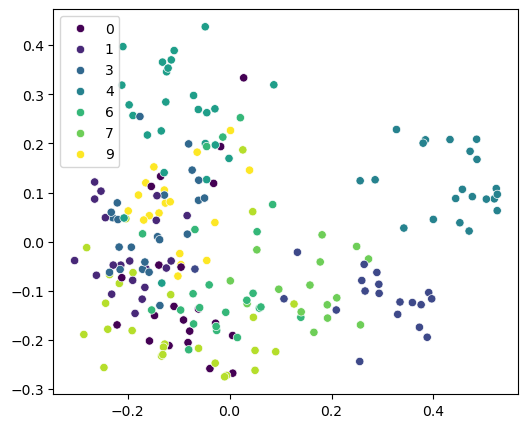

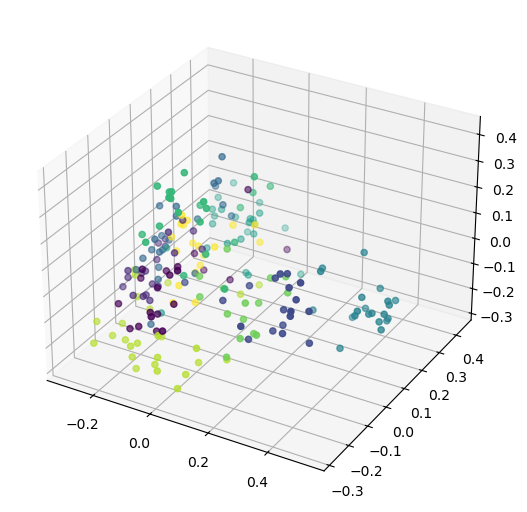

In [9]:
features_scaled = scaled_features(features, 40, 57)
plot_2D_scatterplot(features_scaled, labels)
plot_3D_scatterplot(features_scaled, labels)
plt.show()

<h1 style = "color:red;text-align: center;font-size:50px"> <b>
    K-Means
</b> </h1>

<h1 style = "color:green;font-size:30px" dir = "ltr"> <b>
    The Basic Idea:
</b> </h1>

K-means is a widely recognized unsupervised machine learning algorithm used for clustering, which aims to partition a dataset into a predefined number of clusters (K). The algorithm works by assigning each data point to the nearest centroid, with the goal of minimizing the total intra-cluster variance. This process involves iteratively recalculating the centroids based on the mean of all points in each cluster and reassigning points to the nearest centroid until the algorithm converges to a stable solution. The choice of the number of clusters (K) is crucial and can significantly impact the results.

![image](https://stanford.edu/~cpiech/cs221/img/kmeansViz.png)

In [10]:
class K_Means:
    def __init__(self, points,k=2, random_seed=0 , max_iter = 10):
        self.k = k
        self.max_iterations = max_iter
        self.random_seed = random_seed
        self.points = points

    def euclidean_distance(self, point1, point2):
        return np.linalg.norm(point1 - point2)
    
    def get_random_centroids(self, random_seed):
        np.random.seed(random_seed) 
        random_numbers = np.random.choice(range(self.points.shape[0]), size=self.k, replace=False)
        centroids = {i:self.points[random_index] for i, random_index in enumerate(random_numbers)}
        return centroids
    
    def clustering_points(self):
        clusters = {i:[] for i in range(self.k)}
        for i in range(self.points.shape[0]):
            distances = {key:self.euclidean_distance(self.points[i], value) for key, value in self.centroids.items()}
            cluster_index = min(distances, key=distances.get)
            clusters[cluster_index].append(i)       
        return clusters

    def get_new_centroids(self,previous):
        centroids = {}
        for cluster_index, points_index_in_cluster in self.clusters.items():
            cluster_points = [self.points[index] for index in points_index_in_cluster]
            if len(cluster_points) > 0:
                centroids[cluster_index] = np.mean(np.array(cluster_points), axis=0)
            else:
                centroids[cluster_index] = previous[cluster_index]
        return centroids

    def has_centroids_covered(self, previous):
        for index in range(self.k):
            if np.linalg.norm(previous[index] - self.centroids[index]) != 0:
                return False
        return True 
    
    def get_cluster_labels(self, clusters, k, points):        
        new_labels = [0] * len(points)
        for i in range(k):
            for point_index in clusters[i] :
                new_labels[point_index] = i 
        return new_labels

    def fit(self):
        self.centroids = self.get_random_centroids(self.random_seed)

        for _ in range(self.max_iterations):
            print(_)
            self.clusters = self.clustering_points()
            previous = dict(self.centroids)
            self.centroids = self.get_new_centroids(previous)
            if self.has_centroids_covered(previous):
                break
        return self.get_cluster_labels(self.clusters, self.k, self.points)

<h1 style = "color:green;font-size:30px" dir = "ltr"> <b>
    Elbow Method:
</b> </h1>

The Elbow Method is a technique used in k-means clustering to determine the optimal number of clusters (k). It involves plotting the explained variation (or within-cluster sum of squares, WCSS) against the number of clusters. The method suggests that the optimal number of clusters is the point at which the addition of more clusters does not significantly decrease the WCSS, forming an "elbow" shape in the graph. This point is chosen as the optimal k because it represents a balance between having too few clusters (which may oversimplify the data) and too many clusters (which may overcomplicate the data without providing additional insight).

The Elbow Method is implemented by iterating through different values of k, from 1 to a chosen maximum (n), and calculating the WCSS for each. The WCSS is defined as the sum of the squared distances between each data point and its assigned cluster centroid. By plotting these values, the method visually identifies the elbow point, which is the point where adding more clusters does not significantly improve the model's fit to the data.

However, it's important to note that the Elbow Method has its limitations. In many real-world datasets, there may not be a clear elbow point, making it challenging to determine the optimal k. In such cases, other methods like the silhouette score might be more reliable for determining the optimal number of clusters.

In [11]:
features_scaled = scaled_features(features, 40, 57)
features_p = get_pca_features(features_scaled, 5, 1)
labels_df = pd.read_csv(os.path.join(directory_path, labels_csv_file))
labels_count = labels_df["label"].nunique()
print(f"Number of unique labels in csv file: {labels_count}")

Number of unique labels in csv file: 10


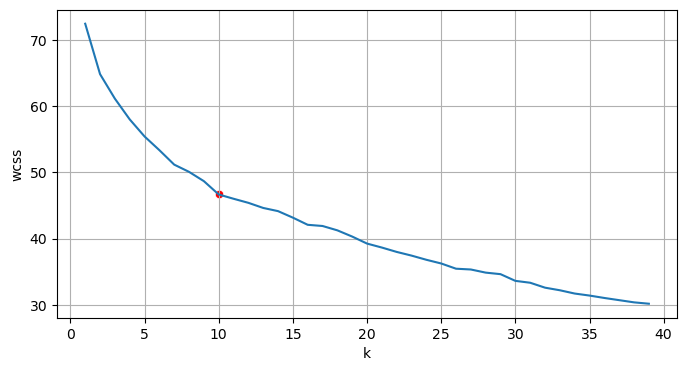

In [12]:
k_max = 40
wcss = []
for k in range(1, k_max, 1):
    kmeans = KMeans(n_clusters = k, init = 'k-means++', max_iter = 20, n_init = 5, random_state = 61)
    pred_labels = kmeans.fit_predict(features_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, k_max), wcss)
sns.scatterplot(x=[10], y=[wcss[9]], color= "r")
plt.xlabel('k')
plt.ylabel('wcss')
plt.grid()
plt.show()

In [13]:
print(f"k= {10}")
kmeans = KMeans(n_clusters = 10, init = 'k-means++', max_iter = 50, n_init = 5, random_state = 61)
pred_labels = kmeans.fit_predict(features_scaled)
print("clusters:")
print(pred_labels)

k= 10
clusters:
[7 7 9 7 7 4 8 7 7 7 8 7 7 3 3 4 7 7 1 8 9 5 3 5 8 1 9 8 3 1 2 7 8 8 0 6 8
 2 9 7 7 4 3 2 4 5 3 2 6 4 0 5 3 2 2 1 8 6 8 6 9 4 3 6 2 8 1 2 1 5 8 3 2 4
 8 2 1 8 6 0 4 5 0 2 7 8 9 5 1 5 3 4 8 9 4 8 6 2 6 2 4 9 5 8 4 9 6 8 6 7 8
 5 9 7 8 7 6 1 2 6 8 9 5 8 4 2 9 7 6 1 8 9 4 5 8 6 7 1 9 5 2 5 7 8 9 3 6 5
 0 0 9 5 3 8 2 2 0 8 0 2 1 0 0 3 6 0 3 0 0 8 0 4 0 2 6 8 4 5 3 3 7 8 6 1 7
 7 1 7 0 3 5 3 4 8 6 0 1 8 1 5 0 2 8 2 5 1 7 5 1 0]


<h1 style = "color:green;font-size:30px" dir = "ltr"> <b> <a id='top1'></a> 
    Evaluation and analysis:
</b> </h1>

- **Homogeneity Score**: The Homogeneity Score is a metric used to evaluate the quality of clustering results, specifically focusing on how similar the data points within each cluster are to each other. It measures the degree to which all data points within a cluster belong to the same class. A clustering result is considered homogeneous if each cluster contains only data points that are members of a single class. The score ranges from 0.0 to 1.0, where 1.0 indicates a perfectly homogeneous labeling, meaning that all data points within each cluster are of the same class. This metric is particularly useful in unsupervised learning scenarios where the true class labels are not known, allowing for the assessment of clustering quality based on the similarity of data points within clusters. It's important to note that the Homogeneity Score is not symmetric, meaning that switching the true labels with the predicted labels will yield a different score, specifically the Completeness Score.

- **Silhouette Score**: The Silhouette Score is a measure used to evaluate the quality of clustering, particularly in k-means clustering. It is an intrinsic method, meaning it does not require ground truth labels to assess the clustering performance. The Silhouette Score is calculated for each data point in the dataset and is based on the silhouette coefficient, which ranges from -1 to 1. A silhouette coefficient close to 1 indicates that the data point is well-matched to its own cluster and poorly matched to neighboring clusters. Conversely, a coefficient close to -1 suggests that the data point is poorly matched to its own cluster and well-matched to neighboring clusters. A score of 0 indicates overlapping clusters.

    The Silhouette Score is particularly useful when the ground truth labels are not available, making it a valuable tool for assessing the effectiveness of clustering algorithms. It provides a more nuanced understanding of clustering quality compared to the Elbow Method, which relies on the visual inspection of a plot of the within-cluster sum of squares against the number of clusters. The Silhouette Score can help identify the optimal number of clusters by indicating the point at which the silhouette scores are highest, suggesting that the clustering is well-defined and cohesive.

Homogeneity Score= 0.71
Silhouette Score= 0.26


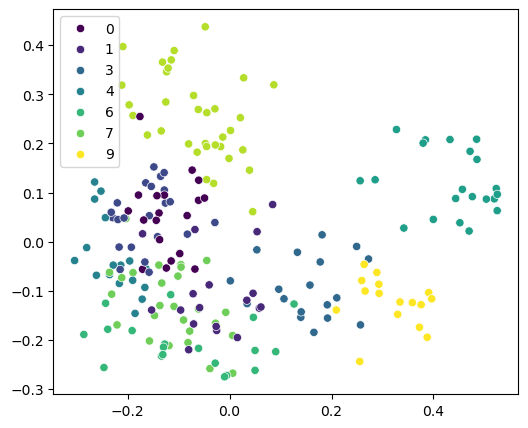

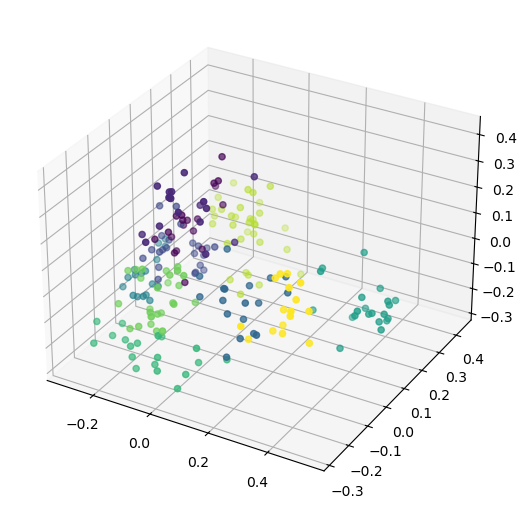

In [14]:
homo_score = homogeneity_score(labels, pred_labels)
print(f"Homogeneity Score= {homo_score:.2f}")

silho_score = silhouette_score(features_p, pred_labels)
print(f"Silhouette Score= {silho_score:.2f}")

plot_2D_scatterplot(features_scaled, pred_labels)
plot_3D_scatterplot(features_scaled, pred_labels)

In [15]:
features_scaled = scaled_features(features, 2, 1)
kmeans = KMeans(n_clusters = 10, init = 'k-means++', max_iter = 50, n_init = 5, random_state = 1)
pred_labels = kmeans.fit_predict(features_scaled)

homo_score = homogeneity_score(labels, pred_labels)
silho_score = silhouette_score(features_scaled, pred_labels)
print(f"Homogeneity Score= {homo_score:.2f}")
print(f"Silhouette Score= {silho_score:.2f}")

Homogeneity Score= 0.51
Silhouette Score= 0.39


<h1 style = "color:red;text-align: center;font-size:50px"> <b>
    DBSCAN
</b> </h1>

<h1 style = "color:green;font-size:30px" dir = "ltr"> <b>
    The Basic Idea:
</b> </h1>

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a density-based clustering algorithm that was introduced in 1996. It is particularly known for its ability to identify clusters of arbitrary shapes and sizes, making it versatile for various clustering tasks. Unlike partition-based clustering methods like k-means, which require the user to specify the number of clusters, DBSCAN automatically determines the number of clusters based on the data's density.

DBSCAN operates by defining two key hyperparameters:

- **Epsilon (ε)**: The maximum distance between two points for them to be considered as neighbors.
- **Min_samples**: The minimum number of neighbors a point must have to be considered a core point. This includes the point itself.

The algorithm starts by identifying core points, which are points that have at least min_samples within a radius of ε. It then expands clusters from these core points by adding points that are within the ε distance of the core points. Points that are not part of any cluster are considered noise or outliers.

DBSCAN is particularly useful for datasets with clusters of varying densities and shapes, and it can also identify noise points that do not belong to any cluster. It has been implemented in various programming languages and frameworks, including Python's scikit-learn and R's dbscan package. 

![image](https://miro.medium.com/v2/resize:fit:828/format:webp/1*KqWII7sFp1JL0EXwJGpqFw.png)

In [21]:
class DBSCAN_SCR:
    def __init__(self, eps = 0.01, min_samples = 5):
        self.eps = eps
        self.min_samples = min_samples
        self.cluster_count = 0

    def euclidean_distance(self, point1, point2):					
        return np.linalg.norm(point1-point2)					

    def get_range_query(self, data, i):				
        point_count = len(data)					
        neighbours = np.array([], dtype=int)	
        for j in np.arange(point_count):
            distance = self.euclidean_distance(data[i], data[j])	
            if distance <= self.eps: 					
                neighbours = np.append(neighbours, [j])	
        return neighbours
    
    def get_clusters(self, data):						
        point_count = len(data)						
        labels = np.zeros((point_count), dtype=int)

        for i in np.arange(point_count):			
            if labels[i] != 0 :						
                continue
            
            neighbours = self.get_range_query(data, i)	
            if len(neighbours) < self.min_samples:		
                labels[i] = -1						
                continue

            self.cluster_count = self.cluster_count + 1	
            labels[i] = self.cluster_count			

            seed_set = np.setdiff1d(neighbours, [i])	
            for k in seed_set:
                if labels[k] == -1:					
                    labels[k] = self.cluster_count	
                if labels[k] != 0:					
                    continue

                labels[k] = self.cluster_count		
                other_neighbours = self.get_range_query(data, k) 
                if len(other_neighbours) >= self.min_samples:	
                    seed_set = np.append(seed_set, other_neighbours)

        return labels
        

<h1 style = "color:green;font-size:30px" dir = "ltr"> <b>
    find optimal 'eps':
</b> </h1>

The Silhouette Score can indeed help identify the optimal eps (epsilon) value in DBSCAN by indicating the point at which the silhouette scores are highest. This method involves evaluating the quality of clustering for different eps values and selecting the one that results in the highest average silhouette score. The silhouette score measures how well each data point fits within its assigned cluster compared to neighboring clusters.

To find the optimal eps using the Silhouette Score, I would typically perform a grid search over a range of eps values. For each eps value, I would run DBSCAN and calculate the average silhouette score for the resulting clusters. The eps value that yields the highest silhouette score is considered the optimal choice, as it indicates the best separation and cohesion within the clusters.

In [16]:
def find_optimal_eps(features_scaled, labels):
    min_samples = range(1,9)
    eps = np.arange(0.1,0.2, 0.001)

    output = []
    for ms in min_samples:
        for ep in eps:
            pred_labels = DBSCAN(min_samples=ms, eps = ep).fit(features_scaled).labels_
            # pred_labels[-1] = 100
            sil_score = silhouette_score(features_scaled, pred_labels)
            homo_score = homogeneity_score(labels, pred_labels)
            output.append((ms, ep, np.sqrt(sil_score)*((homo_score)**2)))

    min_sample, eps, score = sorted(output, key=lambda x:x[-1])[-1]
    return min_sample, eps

def find_NearestNeighbors(min_sample, features_scaled):
    nn = NearestNeighbors(n_neighbors= min_sample+1).fit(features_scaled)
    distances, indices = nn.kneighbors(features_scaled)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    return distances

def plot_NearestNeighbors(distances, min_sample, eps, features_scaled):
    plt.plot(distances)
    plt.plot(eps/2 * np.ones(features_scaled.shape[0]), '--')
    plt.xlabel(f'Sorted Points According to Distance of {min_sample}rd Nearest Neighbor')
    plt.ylabel(f'{min_sample}rd Nearest Neighbor Distance')
    plt.xlim((0,len(distances)))
    plt.grid()
    plt.show()

min_samples: 8
eps: 0.17500000000000007


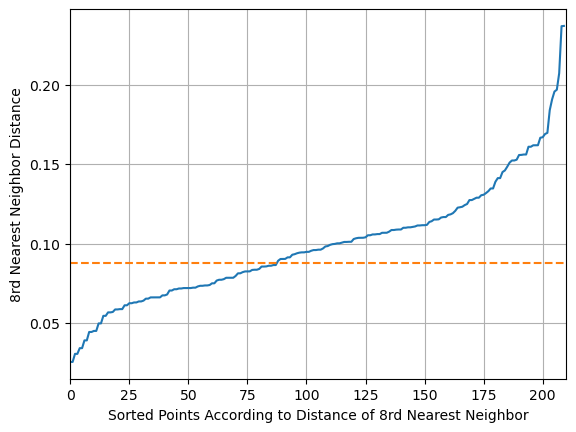

In [22]:
features_scaled = scaled_features(features, 5, 45)
min_sample, eps = find_optimal_eps(features_scaled, labels)
print(f"min_samples: {min_sample}")
print(f"eps: {eps}")
distances = find_NearestNeighbors(min_sample, features_scaled)
plot_NearestNeighbors(distances, min_sample, eps, features_scaled)


In [23]:
dbscan = DBSCAN(eps=eps, min_samples=min_sample)
pred_labels = dbscan.fit_predict(features_scaled)

print("clusters:")
print(pred_labels)

clusters:
[-1  0  1  0  0  0 -1  0  0  0  0  0 -1  4  4  0  0  0 -1  0  1  5  4  5
  0  2  1  0  4  2  0 -1  0  0  0  3  0  0  1  0  0  0  4  0  0  5  4  0
  3  0  0  5  4  0 -1  2  0  3  0  3  1  0  4 -1  0  0  0  0 -1  5  0  4
  0  0  0  0  2  0  3 -1  0 -1 -1  0  0  0  1  5  2  5 -1  0  0  1  0  0
  3  0  3  0  0 -1  5  0  0  1  3  0  0  0  0  5  1  0  0  0  3  2  0  0
  0  1 -1  0  0  0  1  0  3  2  0  1  0 -1 -1  3  0  2  1  5  0  5  0  0
  1  4  3  5  0  0  1 -1  4  0  0  0  0 -1  0  0 -1  0  0 -1  0  0  4  0
  0  0  0  0  0  0  0  0  0  5 -1 -1  0  0 -1  2  0  0 -1  0  0 -1  5 -1
  0  0  3  0 -1  0 -1 -1  0  0 -1  0  5  2  0  5 -1  0]


<h1 style = "color:green;font-size:30px" dir = "ltr"> <b> <a id='top2'></a> 
    Evaluation and analysis:
</b> </h1>

- **Homogeneity Score**: The Homogeneity Score is a metric used to evaluate the quality of clustering results, specifically focusing on how similar the data points within each cluster are to each other. It measures the degree to which all data points within a cluster belong to the same class. A clustering result is considered homogeneous if each cluster contains only data points that are members of a single class. The score ranges from 0.0 to 1.0, where 1.0 indicates a perfectly homogeneous labeling, meaning that all data points within each cluster are of the same class. This metric is particularly useful in unsupervised learning scenarios where the true class labels are not known, allowing for the assessment of clustering quality based on the similarity of data points within clusters. It's important to note that the Homogeneity Score is not symmetric, meaning that switching the true labels with the predicted labels will yield a different score, specifically the Completeness Score.

- **Silhouette Score**: The Silhouette Score is a measure used to evaluate the quality of clustering, particularly in k-means clustering. It is an intrinsic method, meaning it does not require ground truth labels to assess the clustering performance. The Silhouette Score is calculated for each data point in the dataset and is based on the silhouette coefficient, which ranges from -1 to 1. A silhouette coefficient close to 1 indicates that the data point is well-matched to its own cluster and poorly matched to neighboring clusters. Conversely, a coefficient close to -1 suggests that the data point is poorly matched to its own cluster and well-matched to neighboring clusters. A score of 0 indicates overlapping clusters.

    The Silhouette Score is particularly useful when the ground truth labels are not available, making it a valuable tool for assessing the effectiveness of clustering algorithms. It provides a more nuanced understanding of clustering quality compared to the Elbow Method, which relies on the visual inspection of a plot of the within-cluster sum of squares against the number of clusters. The Silhouette Score can help identify the optimal number of clusters by indicating the point at which the silhouette scores are highest, suggesting that the clustering is well-defined and cohesive.

Homogeneity Score= 0.43
Silhouette Score= 0.20


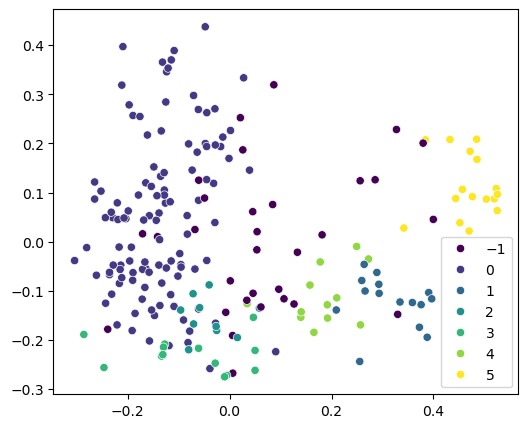

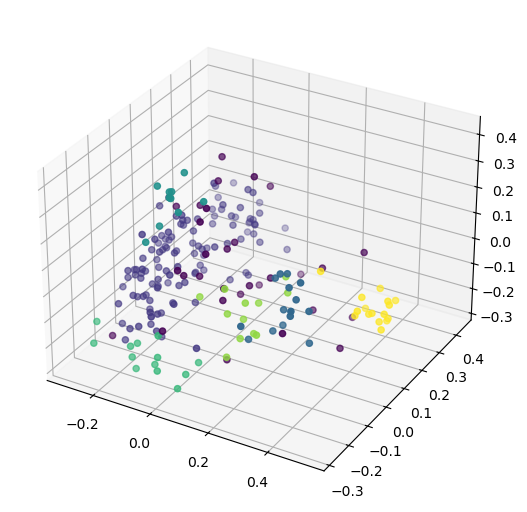

In [24]:
homo_score = homogeneity_score(labels, pred_labels)
print(f"Homogeneity Score= {homo_score:.2f}")

silho_score = silhouette_score(features_scaled, pred_labels)
print(f"Silhouette Score= {silho_score:.2f}")

plot_2D_scatterplot(features_scaled, pred_labels)
plot_3D_scatterplot(features_scaled, pred_labels)

<h1 style = "color:red;text-align: center;font-size:50px"> <b>
    Questions
</b> </h1>

<h1 style = "color:green;font-size:20px" dir = "ltr"> <b>
    1- What is the reason for feature extraction? Explain why don't we just use the pixels?   
</b> </h1>

- **High Dimensionality**: An image is essentially a grid of pixels, each with its own color value.  For a typical image, this translates to a massive amount of data points.  Using all the pixels directly as features can be computationally expensive and lead to the curse of dimensionality, where algorithms struggle to perform well in high dimensional spaces.

- **Irrelevant Information**:  Raw pixel data contains a lot of information that might not be relevant for your specific task (flower classification). Things like lighting variations or slight background changes can show up in the pixel values, making it harder to distinguish between the actual flower features.

- **Feature Engineering**: Feature extraction allows me to transform the raw pixel data into a more compact and informative set of features. These features can be specifically chosen to capture the important characteristics of the flowers, like color histograms, edge shapes, or textures.

- **Improved Performance**: By using a reduced set of meaningful features,  classification algorithms can learn more effectively and achieve better accuracy. This is because the focus is on the key aspects that differentiate the flowers, rather than getting bogged down in irrelevant details.

<h1 style = "color:green;font-size:20px" dir = "ltr"> <b>
    2- Research about feature extraction from photos and briefly explain about 3 techn-iques.
</b> </h1>

Here are three common techniques for feature extraction from photos:

- **Color-based features**: This technique focuses on capturing information about the colors present in the image. Common methods include:
    - **Color Histograms**: These represent the distribution of colors within an image. Essentially, it's a bar graph showing how many pixels fall into each color range. This helps identify dominant colors and color combinations that might be characteristic of different flower types.
    - **Color Moments**: Statistical measures like mean, standard deviation, and skewness are calculated for different color channels (red, green, blue). These provide insights into the overall color properties of the image, potentially helping differentiate flowers with distinct color palettes.

- **Texture-based features**: This technique aims to capture the textural patterns within the image. It's useful for distinguishing flowers with different petal textures, like smooth roses or rough carnations. Some common methods include:
    - **Local Binary Patterns (LBP)**: This compares a pixel's intensity to its neighbors and encodes the results in a binary pattern. These patterns capture local textural variations and are useful for identifying repetitive patterns like stripes or spots on flower petals.
    - **Gabor Filters**: These are like tiny templates that capture specific textural orientations and frequencies. By applying these filters across the image, you can extract features that represent the dominant textures present.

- **Edge and shape-based features**: This technique focuses on identifying edges and shapes within the image. It's helpful for tasks where flower shapes are a key differentiating factor. Here are some common approaches:
    - **Canny Edge Detection**: This algorithm identifies prominent edges in the image, outlining the flower's overall shape and petal boundaries.
    - **Hu Moments**: These are mathematical measures that capture the overall shape characteristics of an object in the image. This can be useful for distinguishing flowers with different petal arrangements or geometric shapes.


<h1 style = "color:green;font-size:20px" dir = "ltr"> <b>
    3- What pre-processing should be done on the images so that they are ready to be entered into the model?
</b> </h1>

- **Resize**: VGG16, like most pre-trained models, expects images of a specific size as input.  Resize all your flower images to the dimensions required by VGG16 (typically 224x224 pixels). This ensures all images are compatible with the model's architecture.

- **Normalization**:  Raw pixel values in images typically range from 0 to 255. VGG16, however, expects the pixel values to be within a specific range (often -1 to 1 or 0 to 1). Normalize your image data by subtracting a specific mean value (often calculated from the training data used for VGG16) from each pixel and then dividing by a certain factor. This puts all images on a common scale and helps the model learn more effectively.

- **Channel Order**: Depending on the framework you're using (TensorFlow, PyTorch etc.), images might be represented with channels in different orders (RGB or BGR). Ensure your images are converted to the channel order expected by VGG16. This is usually RGB (Red, Green, Blue) but  check the documentation for your specific framework.

<h1 style = "color:green;font-size:20px" dir = "ltr"> <b>
    4- Explain about the K-Means and DBSCAN methods and their advantages and disadvantages.
</b> </h1>

- **K-Means**: K-means is a widely recognized unsupervised machine learning algorithm used for clustering, which aims to partition a dataset into a predefined number of clusters (K). The algorithm works by assigning each data point to the nearest centroid, with the goal of minimizing the total intra-cluster variance. This process involves iteratively recalculating the centroids based on the mean of all points in each cluster and reassigning points to the nearest centroid until the algorithm converges to a stable solution. The choice of the number of clusters (K) is crucial and can significantly impact the results.

    Advantages:
    - Scales efficiently to large datasets.
    - The process is relatively straightforward to implement.
    - Guarantees convergence.

    Disadvantages:
    - It is essential to manually select the value of K in k-means clustering.
    - Being dependent on initial values can significantly impact the performance and accuracy
    - Performs exceptionally well for clusters that are distinctly separated and circular in nature.
    - formation of separate clusters for outliers and altering the composition of existing clusters.   

- **DBSCAN**: DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a density-based clustering algorithm that was introduced in 1996. It is particularly known for its ability to identify clusters of arbitrary shapes and sizes, making it versatile for various clustering tasks. Unlike partition-based clustering methods like k-means, which require the user to specify the number of clusters, DBSCAN automatically determines the number of clusters based on the data's density.

    DBSCAN operates by defining two key hyperparameters:

    - **Epsilon (ε)**: The maximum distance between two points for them to be considered as neighbors.
    - **Min_samples**: The minimum number of neighbors a point must have to be considered a core point. This includes the point itself.

    The algorithm starts by identifying core points, which are points that have at least min_samples within a radius of ε. It then expands clusters from these core points by adding points that are within the ε distance of the core points. Points that are not part of any cluster are considered noise or outliers.

    Advantages:
    - identify clusters of arbitrary shapes.
    - identify cluster completely surrounded by other clusters.
    - robustness in outlier detection 
    - effectively handling noise in the data.

    Disadvantages:
    - highly sensitive to the choice of hyperparameters, particularly min_samples and eps, which can make it challenging to select appropriate values without a deep understanding of the data.
    - struggle with datasets where the density of clusters varies significantly.
    - It does't work well for small data sets


<h1 style = "color:green;font-size:20px" dir = "ltr"> <b>
    5- Explain what method have you used to find the most appropriate K in the K-Means?
</b> </h1>

The Elbow Method is a technique used in k-means clustering to determine the optimal number of clusters (k). It involves plotting the explained variation (or within-cluster sum of squares, WCSS) against the number of clusters. The method suggests that the optimal number of clusters is the point at which the addition of more clusters does not significantly decrease the WCSS, forming an "elbow" shape in the graph. This point is chosen as the optimal k because it represents a balance between having too few clusters (which may oversimplify the data) and too many clusters (which may overcomplicate the data without providing additional insight).

The Elbow Method is implemented by iterating through different values of k, from 1 to a chosen maximum (n), and calculating the WCSS for each. The WCSS is defined as the sum of the squared distances between each data point and its assigned cluster centroid. By plotting these values, the method visually identifies the elbow point, which is the point where adding more clusters does not significantly improve the model's fit to the data.

However, it's important to note that the Elbow Method has its limitations. In many real-world datasets, there may not be a clear elbow point, making it challenging to determine the optimal k. In such cases, other methods like the silhouette score might be more reliable for determining the optimal number of clusters.

<h1 style = "color:green;font-size:20px" dir = "ltr"> <b>
    6- Compare the output of two types of clustering.
</b> </h1>

In this project, the performance of k-means and DBSCAN clustering algorithms is evaluated, revealing distinct advantages and limitations. K-means demonstrates superior performance, achieving a 71% homogeneity scores in categorizing the data. This method's efficiency is particularly notable due to its linear time complexity, making it highly scalable for large datasets. However, k-means's performance is heavily influenced by the choice of the number of clusters (k), which must be predefined and can significantly affect the clustering outcome.

DBSCAN, on the other hand, excels in identifying and handling noise, discovering clusters of varying shapes, and does not require the predefinition of the number of clusters. However, DBSCAN may struggle with sparse datasets or those with varying densities like this data set, as it relies on the density of data points to form clusters.

<h1 style = "color:green;font-size:20px" dir = "ltr"> <b>
    7- Research about PCA and briefly explain how it works.
</b> </h1>

Principal Component Analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. This transformation is defined in such a way that the first principal component has the largest possible variance, and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components. The resulting vectors are an uncorrelated orthogonal basis set. 

The process of PCA involves several steps:

1. **Standardization**: The data is standardized to have a mean of 0 and a standard deviation of 1. This ensures that all variables contribute equally to the analysis, regardless of their original scale.
2. **Covariance Matrix Calculation**: The covariance matrix is calculated to measure the correlation between the variables.
3. **Eigenvalue Decomposition**: The covariance matrix is decomposed into eigenvalues and eigenvectors. The eigenvectors represent the directions or components for the reduced subspace of the dataset, while the eigenvalues represent the magnitude of the variance in the data along these directions.
4. **Sorting Eigenvalues**: The eigenvalues are sorted in descending order, and the corresponding eigenvectors are selected.
5. **Projection**: The original data is projected onto the new subspace defined by the selected eigenvectors. This projection results in a new set of variables, the principal components, which are uncorrelated and capture the maximum variance in the data

<h1 style = "color:green;font-size:20px" dir = "ltr"> <b>
    8- Explain how to calculate silhouette and homogeneity scores.
</b> </h1>

- **Silhouette Score**: The silhouette score measures how similar an object is to its own cluster compared to other clusters. The silhouette score ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

    To calculate the silhouette score:

    1. For each cluster, calculate the average distance between each point in the cluster and all other points in the cluster. This is known as the within-cluster distance.
    2. For each point, calculate the average distance between that point and all points in the nearest cluster. This is known as the between-cluster distance.
    3. The silhouette score for each point is then calculated as (b - a) / max(a, b), where a is the within-cluster distance and b is the between-cluster distance.
    4. The overall silhouette score is the mean of the silhouette scores for all points

- **Homogeneity Score**: The homogeneity score measures the extent to which clusters are homogeneous, i.e., the extent to which each cluster contains only data points which are similar to each other. A high homogeneity score indicates that the clusters are well defined.

    To calculate the homogeneity score:

    1. For each cluster, calculate the number of points that are correctly assigned to the cluster.
    2. The homogeneity score is then calculated as the sum of these correct assignments divided by the total number of points.

<h1 style = "color:green;font-size:20px" dir = "ltr"> <b>
    9- Report the results of the mentioned criteria for each of the methods.
</b> </h1>

Refer to the analysis and evaluation section:
   
- [analysis and evaluation of K-means method](#top1)

- [analysis and evaluation of DBSCAN method](#top2) 

<h1 style = "color:green;font-size:20px" dir = "ltr"> <b>
    10- Suggest some solutions that can improve the performance of the models.
</b> </h1>

- **Preprocessing Enhancements**:

    - **Color Correction**: Inconsistent lighting or camera settings can lead to color variations in my images. Consider techniques like white balancing or histogram equalization to achieve more consistent color representation across images, potentially improving clustering based on color features.
    - **Background Removal**: If the background is not a key feature for flower classification, segmenting and removing the background can help focus the clustering algorithms on the flower itself and reduce noise from irrelevant background elements.
    - **Data Augmentation**: Explore techniques like random cropping, color jittering, or random flips to create more variations of my existing flower images. This can help clustering algorithms learn from a more diverse dataset and potentially improve their ability to generalize to unseen flower images.

- **Noise Reduction**:

    - **Median Filtering**: This technique replaces each pixel with the median value of its neighboring pixels. It's effective in reducing salt-and-pepper noise (random black or white pixels) that might be present in my images.
    - **Gaussian Filtering**: This technique applies a Gaussian blur to the image, which essentially averages neighboring pixel values. It can help smooth out high-frequency noise while preserving edges important for flower identification.

- **Model Exploration**:

    - **Hierarchical Clustering**: Unlike K-Means, hierarchical clustering doesn't require pre-defining the number of clusters. It builds a hierarchy of clusters, allowing me to explore the data and choose the most appropriate granularity for my flower categorization.
    - **Spectral Clustering**: This method leverages spectral graph theory to group data points. It can be effective when the data has underlying cluster structures that might not be easily captured by K-Means or DBSCAN, potentially leading to more accurate flower groupings.

- **Beyond VGG16**:

    - **Fine-tuning VGG16**: While VGG16 is a powerful model, I can consider fine-tuning it on my flower dataset. This involves freezing the initial layers of VGG16 (which capture generic image features) and retraining the final layers on my specific flower classification task. This can potentially improve the model's ability to extract flower-specific features relevant for clustering.
    - **Deeper Convolutional Neural Networks (CNNs)**: If computational resources and data availability allow, explore using deeper CNN architectures specifically designed for flower classification tasks. These models might capture more complex image features and relationships, potentially leading to improved clustering performance.

<h1 style = "color:red;text-align: center;font-size:50px"> <b>
    References
</b> </h1>

https://www.analyticsvidhya.com/blog/2021/06/transfer-learning-using-vgg16-in-pytorch/

https://discuss.pytorch.org/t/understanding-transform-normalize/21730

https://www.geeksforgeeks.org/dbscan-clustering-in-ml-density-based-clustering/

https://medium.com/@okanyenigun/dbscan-demystified-understanding-how-this-parameter-free-algorithm-works-89e03d7d7ab

https://www.youtube.com/watch?v=RDZUdRSDOok

https://datagen.tech/guides/computer-vision/vgg16/#:~:text=VGG16%20has%20three%20fully%20connected,the%20center%20of%20each%20image.

https://muthu.co/mathematics-behind-k-mean-clustering-algorithm/

https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/

https://www.kaggle.com/code/tanmaymane18/nearestneighbors-to-find-optimal-eps-in-dbscan

https://stats.stackexchange.com/questions/88872/a-routine-to-choose-eps-and-minpts-for-dbscan

https://smuhabdullah.medium.com/understanding-vgg16-a-powerful-deep-learning-model-for-image-recognition-d40b074fd01c

https://stanford.edu/~cpiech/cs221/handouts/kmeans.html

https://towardsdatascience.com/understanding-dbscan-algorithm-and-implementation-from-scratch-c256289479c5